1- Data Preprocessing

1.1-Importing Libraries

In [36]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.nn import ReLU, Linear, BatchNorm1d, Dropout, Sequential, Module, BCEWithLogitsLoss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./card_transdata.csv
./projekt.ipynb


1.2- Improting Dataset

In [37]:
dataset = pd.read_csv('./card_transdata.csv')
dataset = dataset.dropna()
dataset.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


<Axes: xlabel='fraud', ylabel='count'>

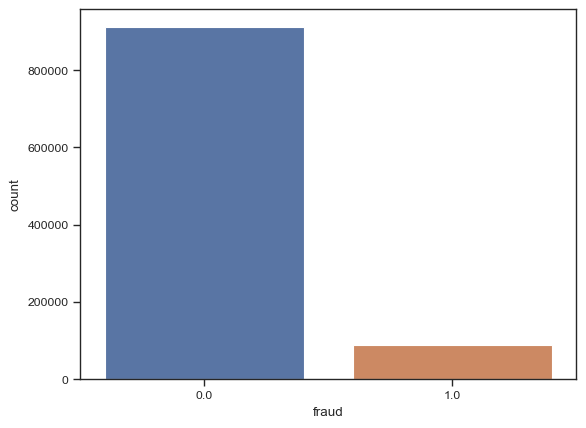

In [39]:
sns.set_context('paper', font_scale=1)
sns.set_style('ticks')
sns.countplot(x='fraud', data=dataset, palette='deep')

We choose all columns as our matrix of features except the last one, which is 'y' column

In [40]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [41]:
dataset.fraud.value_counts()
print('Shape of X: ', np.shape(X))
print('Shape of y: ', np.shape(y))

Shape of X:  (1000000, 7)
Shape of y:  (1000000,)


1.3- Oversampling and Train, Test split

In [42]:
X, y = SMOTE().fit_resample(X, y)
print('Shape of X: ', np.shape(X))
print('Shape of y: ', np.shape(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('Shape of X_train: ', np.shape(X_train))
print('Shape of y_train: ', np.shape(y_train))
print('Shape of X_test: ', np.shape(X_test))
print('Shape of y_test: ', np.shape(y_test))

Shape of X:  (1825194, 7)
Shape of y:  (1825194,)
Shape of X_train:  (1277635, 7)
Shape of y_train:  (1277635,)
Shape of X_test:  (547559, 7)
Shape of y_test:  (547559,)


2- Binary Classification

In [43]:
def plt_acc_loss(train, epochs, plttype):
    epochstoplot = range(1, epochs + 1)
    plt.plot(epochstoplot, train, label='Training' + plttype)
    plt.title('Training ' + plttype)
    plt.xlabel('Epochs')
    plt.ylabel(plttype)
    plt.legend()
    plt.show()

2.1- Deep Learning
Defining Hyperparameters

In [49]:
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.00146
WORKERS = 2
WD = 1e-6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [45]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = TestData(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=True, num_workers=WORKERS)

2.2- Neural Network with 3 different layers

In [46]:
class NeuralNet(Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        #Number of input features is 7.
        self.layer_1 = Linear(7, 64)
        self.layer_2 = Linear(64, 64)
        self.layer_out = Linear(64, 1)

        self.relu = ReLU()
        self.dropout = Dropout(p=0.1)
        self.batchnorm1 = BatchNorm1d(64)
        self.batchnorm2 = BatchNorm1d(64)
    
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
   

In [47]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

<h5><b>2.3- Training<b><h5>

In [50]:
start_time = time.time()

accuracy_stats = []
loss_stats = []

model = NeuralNet()
model.to(device)
loss = BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WD)

model.train()

for i in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        l = loss(y_pred, y_batch.unsqueeze(1))
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        epoch_loss += l.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {i:02d} / {EPOCHS:02d}: | Loss: {epoch_loss/len(train_loader):.4f} | Acc: {epoch_acc/len(train_loader):.3f}')
    loss_stats.append(epoch_loss / len(train_loader))
    accuracy_stats.append(epoch_acc / len(train_loader))


print('\nTraining is completed!')
print('_____________________________')
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

RuntimeError: DataLoader worker (pid(s) 10864, 8644) exited unexpectedly

In [ ]:
plt_acc_loss(loss_stats, EPOCHS, 'Loss')